In [1]:
# !git --version

In [2]:
# !git clone https://github.com/SeongJaeCho/CTAB-GAN.git

In [3]:
import os
os.chdir("CTAB-GAN")
print("현재 작업 디렉토리:", os.getcwd())  # 현재 작업 디렉토리 출력

현재 작업 디렉토리: /home/chosj9908/pytorch_sj/CTAB-GAN


In [4]:
from model.pipeline.data_preparation import DataPrep as DataPreprocess
import json

def read_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

In [5]:
import pandas as pd

# 데이터 로드 (Adult Dataset 사용)
df = pd.read_csv("Real_Datasets/Adult.csv")

# 데이터 확인
print("📌 데이터셋 크기:", df.shape)
df.head()

📌 데이터셋 크기: (48842, 14)


,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,4,0,3,4,0,0,0,30,39,0


In [6]:
# Adult Dataset의 categorical, continuous 변수 지정
categorical_columns = [
    "workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"
]
continuous_columns = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
target_column = "income"  # 분류할 대상 컬럼

In [7]:
# 데이터 전처리 객체 생성
data_prep = DataPreprocess(
    raw_df=df,
    categorical=categorical_columns,
    log=[],
    mixed={},
    integer=continuous_columns,
    type={"Classification": target_column},
    test_ratio=0.2  # Train/Test 분할 비율
)

train = pd.read_csv("train_real_preprocessed.csv")
test = pd.read_csv("test_real_preprocessed.csv")

# 전처리된 데이터 확인
print("📌 훈련 데이터셋 크기:", train.shape)
print("📌 테스트 데이터셋 크기:", test.shape)

✅ 기존 전처리된 train/test 데이터를 불러옵니다.
📌 훈련 데이터셋 크기: (39073, 14)
📌 테스트 데이터셋 크기: (9769, 14)


In [8]:
import importlib
import model.synthesizer.transformer

importlib.reload(model.synthesizer.transformer)

<module 'model.synthesizer.transformer' from '/home/chosj9908/pytorch_sj/CTAB-GAN/model/synthesizer/transformer.py'>

In [11]:
# 올바른 CTABGAN 클래스 import
from model.synthesizer.ctabgan_synthesizer import CTABGANSynthesizer as CTABGAN

# CTAB-GAN 모델 초기화
ctabgan = CTABGAN(
    class_dim=(256, 256, 256, 256),
    random_dim=100,
    num_channels=64,
    l2scale=1e-5,
    batch_size=500,
    epochs=100  # 학습 에포크 설정
)

print("🚀 CTAB-GAN 학습 시작...")

# 데이터 로드
import pandas as pd

df = pd.read_csv("Real_Datasets/Adult.csv")

# 데이터 전처리 (CTAB-GAN에서 요구하는 방식으로)
categorical_columns = [
    "workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"
]
continuous_columns = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
target_column = "income"

# 모델 학습 실행
ctabgan.fit(
    train_data=train,
    categorical=categorical_columns,
    mixed={},
    type={"Classification": target_column}
)

print("✅ CTAB-GAN 학습 완료!")

🚀 CTAB-GAN 학습 시작...


/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or chec

✅ CTAB-GAN 학습 완료!


In [14]:
# ✅ 학습이 끝난 CTAB-GAN 모델 저장
# (transformer, generator, cond_generator 정보를 포함하여 저장)
ctabgan_save_data = {
    "generator": ctabgan.generator.state_dict(),  # Generator 가중치 저장
    "transformer_data": {  # Transformer 관련 데이터 저장
        "meta": ctabgan.transformer.meta,
        "components": ctabgan.transformer.components,
        "ordering": ctabgan.transformer.ordering,
        "output_info": ctabgan.transformer.output_info,
        "output_dim": ctabgan.transformer.output_dim
    },
    "cond_generator": ctabgan.cond_generator  # Conditional Generator 저장
}

# ✅ Pickle로 모델 저장
import pickle
with open("ctabgan_model.pkl", "wb") as f:
    pickle.dump(ctabgan_save_data, f)

# ✅ 학습이 끝난 CTAB-GAN 모델 전체 저장
import torch
torch.save(ctabgan, "ctabgan_model.pth")

print("✅ CTAB-GAN 모델 및 데이터 저장 완료!")

✅ CTAB-GAN 모델 및 데이터 저장 완료!


In [15]:
import numpy as np
import pandas as pd
import torch
import pickle
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# ✅ CTAB-GAN 관련 라이브러리
from model.synthesizer.ctabgan_synthesizer import CTABGANSynthesizer
from model.synthesizer.transformer import DataTransformer

# ========== 1️⃣ 학습된 CTAB-GAN 모델 & 데이터 확인 ==========
try:
    # ✅ 학습된 모델이 있는 경우 바로 사용
    print("✅ 학습된 CTAB-GAN 모델이 감지되었습니다. 기존 모델을 그대로 사용합니다.")
    train_real_preprocessed = pd.read_csv("train_real_preprocessed.csv")  # 원본 훈련 데이터
    test_real_preprocessed = pd.read_csv("test_real_preprocessed.csv") 
    synthetic_data = pd.read_csv("synthetic_data.csv")  # 생성된 데이터
    
    
except FileNotFoundError:
    print("🚨 저장된 데이터가 없습니다! 먼저 학습을 진행한 후 실행하세요.")
    exit()

# synthetic data 후처리
synthetic_data_preprocessed = pd.DataFrame()
for col in synthetic_data.columns:
    changed_values_col = round(synthetic_data[col]).astype(int)
    if col in categorical_columns:
        max_value_col = train_real_preprocessed[col].max()
        min_value_col = train_real_preprocessed[col].min()
        changed_values_col.loc[changed_values_col >= max_value_col] = max_value_col
        changed_values_col.loc[changed_values_col <= min_value_col] = min_value_col

    else: changed_values_col = changed_values_col
    synthetic_data_preprocessed = pd.concat([synthetic_data_preprocessed, changed_values_col], axis=1)

# ✅ 타겟 변수 설정
target_column = "income"  # 실제 데이터셋에 맞게 설정
X_real = train_real_preprocessed.drop(columns=[target_column])
y_real = train_real_preprocessed[target_column]
X_synthetic = synthetic_data_preprocessed.drop(columns=[target_column])
y_synthetic = synthetic_data_preprocessed[target_column]
X_test = test_real_preprocessed.drop(columns=[target_column])
y_test = test_real_preprocessed[target_column]


# ========== 2️⃣ ML 모델 성능 평가 (Real vs Synthetic) ==========
def evaluate_models(X_train, y_train, X_test, y_test, dataset_type="Real"):
    models = {
        "Decision Tree": DecisionTreeClassifier(),
        "SVM": SVC(probability=True),
        "Random Forest": RandomForestClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
    }
    
    results = []
    
    print(f"\n🔍 Evaluating models on {dataset_type} Data...\n")
    for model_name, model in tqdm(models.items(), desc=f"Training {dataset_type} Models"):
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # 성능 평가
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        
        results.append([dataset_type, model_name, accuracy, f1, auc])
    
    return results

# ✅ Real Data로 학습한 모델 평가
real_results = evaluate_models(X_real, y_real, X_test, y_test, dataset_type="Real")

# ✅ Synthetic Data로 학습한 모델 평가
synthetic_results = evaluate_models(X_synthetic, y_synthetic, X_test, y_test, dataset_type="Synthetic")

# Real Data + Synthetic Data
real_synthetic_results = evaluate_models(pd.concat([X_real, X_synthetic]), pd.concat([y_real, y_synthetic]), X_test, y_test, dataset_type="Real + Synthetic")

# ✅ 결과 합치기
results_df = pd.DataFrame(real_results + synthetic_results + real_synthetic_results, columns=["Dataset", "Model", "Accuracy", "F1-Score", "AUC"])
results_df.to_csv("ML_Utility_Evaluation.csv", index=False)  # 결과 저장

print("✅ ML 성능 평가 완료 및 저장!")

/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 학습된 CTAB-GAN 모델이 감지되었습니다. 기존 모델을 그대로 사용합니다.

🔍 Evaluating models on Real Data...



/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training Real Models: 100%|██████████| 5/5 [03:38<00:00, 43.77s/it]



🔍 Evaluating models on Synthetic Data...



/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training Synthetic Models: 100%|██████████| 5/5 [04:13<00:00, 50.63s/it]



🔍 Evaluating models on Real + Synthetic Data...



/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training Real + Synthetic Models: 100%|██████████| 5/5 [17:21<00:00, 208.37s/it]

✅ ML 성능 평가 완료 및 저장!


/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/chosj9908/pytorch_sj/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


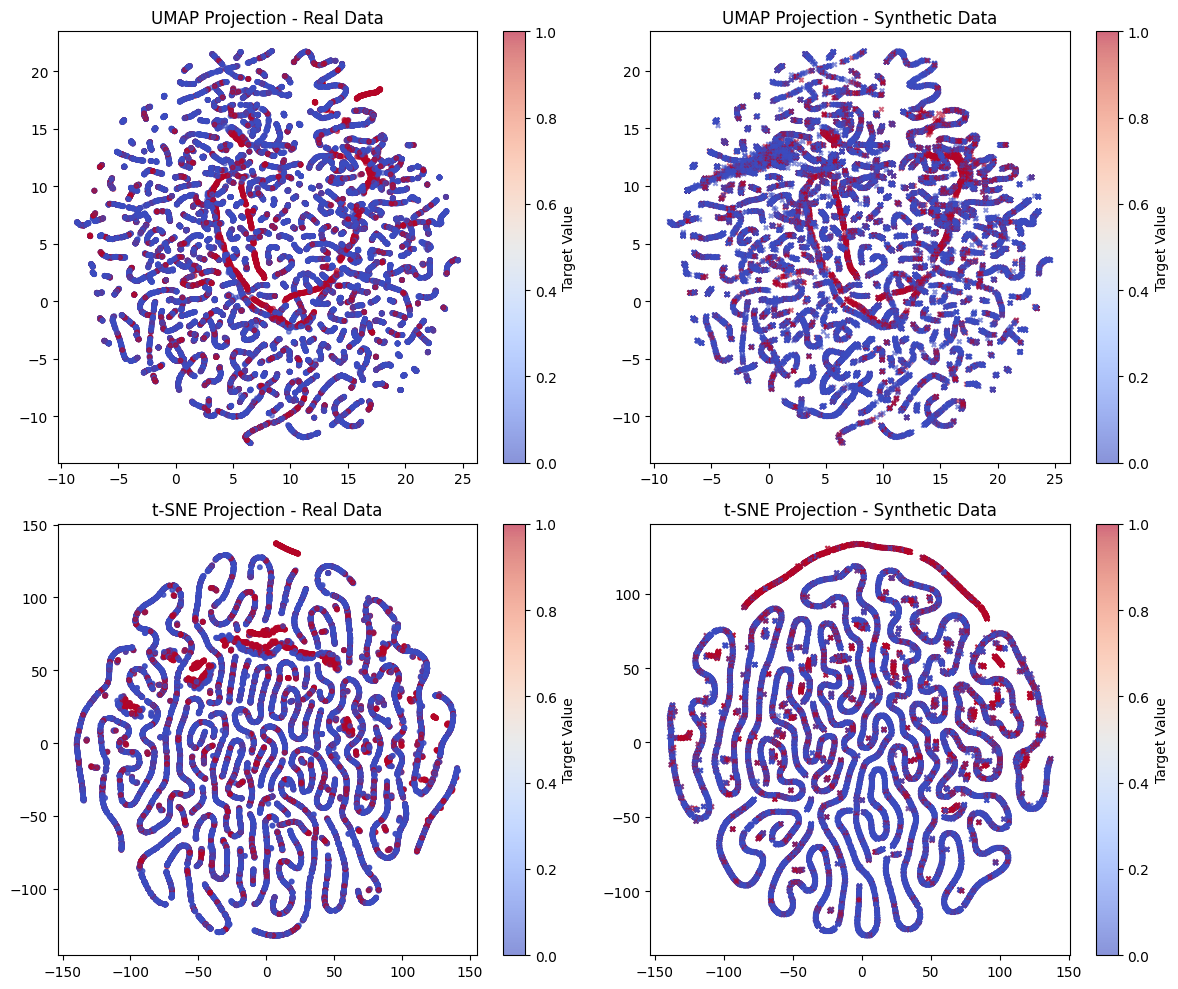

✅ Latent Space 시각화 완료 및 저장!


In [19]:
import umap.umap_ as umap  # 올바른 모듈 경로 사용
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ✅ UMAP을 이용해 2D 차원 축소
reducer_umap = umap.UMAP(n_components=2, random_state=42)
X_real_umap = reducer_umap.fit_transform(X_real)
X_synthetic_umap = reducer_umap.transform(X_synthetic)

# ✅ t-SNE로 변환
reducer_tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_real_tsne = reducer_tsne.fit_transform(X_real)
X_synthetic_tsne = reducer_tsne.fit_transform(X_synthetic)

# ✅ 4x4 서브플롯 구성
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ✅ UMAP - Real Data
sc_real_umap = axes[0, 0].scatter(X_real_umap[:, 0], X_real_umap[:, 1], c=y_real, cmap="coolwarm", alpha=0.6, s=10)
axes[0, 0].set_title("UMAP Projection - Real Data")
fig.colorbar(sc_real_umap, ax=axes[0, 0], label="Target Value")

# ✅ UMAP - Synthetic Data
sc_synth_umap = axes[0, 1].scatter(X_synthetic_umap[:, 0], X_synthetic_umap[:, 1], c=y_synthetic, cmap="coolwarm", alpha=0.6, s=10, marker="x")
axes[0, 1].set_title("UMAP Projection - Synthetic Data")
fig.colorbar(sc_synth_umap, ax=axes[0, 1], label="Target Value")

# ✅ t-SNE - Real Data
sc_real_tsne = axes[1, 0].scatter(X_real_tsne[:, 0], X_real_tsne[:, 1], c=y_real, cmap="coolwarm", alpha=0.6, s=10)
axes[1, 0].set_title("t-SNE Projection - Real Data")
fig.colorbar(sc_real_tsne, ax=axes[1, 0], label="Target Value")

# ✅ t-SNE - Synthetic Data
sc_synth_tsne = axes[1, 1].scatter(X_synthetic_tsne[:, 0], X_synthetic_tsne[:, 1], c=y_synthetic, cmap="coolwarm", alpha=0.6, s=10, marker="x")
axes[1, 1].set_title("t-SNE Projection - Synthetic Data")
fig.colorbar(sc_synth_tsne, ax=axes[1, 1], label="Target Value")

# ✅ 전체 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig("Latent_Space_Comparison.png")
plt.show()

print("✅ Latent Space 시각화 완료 및 저장!")
